In [31]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import loompy
import matplotlib.pyplot as plt
import scipy.optimize
import velocyto as vcy
import glob
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import pickle
import pixiedust
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

2020-01-03 17:53:35,193 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [32]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [33]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

('data/hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7f08eef32cd0>)

In [34]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [35]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict='warn')
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

# Load raw data

2020-01-03 17:54:01,609 - DEBUG - Filtering by detection level


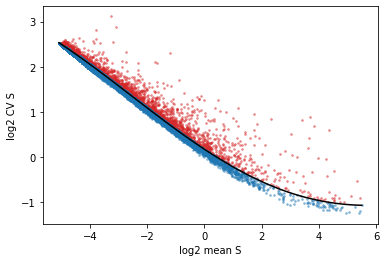

In [36]:
# %%pixie_debugger
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
manual_annotation
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))  # (20, 4) colors
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

# these two lines delete the genes that do not express that much. So brute force; After this line U / S only has 10218 genes
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)  # they filter both on S, U with the same filter

vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)

# Normalizing data

2020-01-03 17:54:15,640 - DEBUG - Filtering by cv vs mean
2020-01-03 17:54:15,665 - INFO - Cluster: 0 (187 cells)
2020-01-03 17:54:15,670 - INFO - Cluster: 1 (332 cells)
2020-01-03 17:54:15,676 - INFO - Cluster: 2 (94 cells)
2020-01-03 17:54:15,679 - INFO - Cluster: 3 (249 cells)
2020-01-03 17:54:15,684 - INFO - Cluster: 4 (347 cells)
2020-01-03 17:54:15,690 - INFO - Cluster: 5 (243 cells)
2020-01-03 17:54:15,694 - INFO - Cluster: 6 (268 cells)
2020-01-03 17:54:15,700 - DEBUG - Filtering by cluster expression
2020-01-03 17:54:15,701 - DEBUG - Filtering by detection level


/home/haotian/anaconda3/envs/velocity/lib/python3.7/site-packages/rpy2/robjects/packages_utils.py:127: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


2020-01-03 17:54:17,051 - DEBUG - First search the 1719 nearest neighbours for 1720
2020-01-03 17:54:17,447 - DEBUG - Using the initialization network to find a 550-NN graph with maximum connectivity of 1719
2020-01-03 17:54:17,467 - DEBUG - Returning sparse matrix


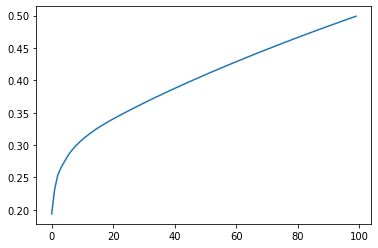

In [38]:
# %%pixie_debugger
vlm.filter_genes(by_cv_vs_mean=True)  # filter here again
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04) # denoise again, similar to filter the expression

vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

from numpy_groupies import aggregate, aggregate_np
pc_obj = principal_curve(vlm.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength  # transfer from distance to similarity
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))  # this is just setting colors
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

k = 550
# you have a knn computing from some pca
# and now you are applying some knn smoothing on the data matrix based on that.
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))

vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")  # the first two axis of the pca

In [39]:
from diffusion.diffusion import Diffusion
from sklearn import preprocessing
diffusion = Diffusion(vlm.Sx_sz.T, './diffusion_cache_Sx_sz')
offline = diffusion.get_offline_results(1000, 21).todense()
features = preprocessing.normalize(offline, norm='l1', axis=1)

[cache] loading ./diffusion_cache/offline.jbl costs 0.01s


In [60]:
def transition_prob2(obj, sims_matrix):
    sims_matrix = sims_matrix.copy()
    hi_dim = obj.Sx_sz
    hi_dim_t = hi_dim + obj.used_delta_t * obj.delta_S
    
    N = hi_dim.shape[1]
    for i in range(N):
        diff_extra = hi_dim_t[:,i] - hi_dim[:,i] # (d,)
        diff_cells = hi_dim - np.expand_dims(hi_dim[:,i],1)  # (d, N)
        direction = (np.expand_dims(diff_extra,1) * diff_cells).sum(0) > 0 # (N,)
        sims_matrix[i] = sims_matrix[i] * direction
        
    sims_matrix = 4 * preprocessing.normalize(sims_matrix, norm='l1', axis=1)
    obj.corrcoef = sims_matrix
    
    # some other attributes just the velocyto need
    obj.corr_calc = "knn_random"
    
def transition_prob3(obj, sims_matrix):
    """the backward to forward direction"""
    sims_matrix = sims_matrix.copy()
    hi_dim = obj.Sx_sz
    hi_dim_t = hi_dim + obj.used_delta_t * obj.delta_S
    
    N = hi_dim.shape[1]
    for i in range(N):
        diff_extra = hi_dim_t[:,i] - hi_dim[:,i] # (d,)
        diff_cells = hi_dim - np.expand_dims(hi_dim[:,i],1)  # (d, N)
        direction = (np.expand_dims(diff_extra,1) * diff_cells).sum(0) < 0 # (N,)
        sims_matrix[i] = sims_matrix[i] * direction
        
    sims_matrix = 4 * preprocessing.normalize(sims_matrix, norm='l1', axis=1)
    obj.corrcoef = sims_matrix
    
    # some other attributes just the velocyto need
    obj.corr_calc = "knn_random"

In [41]:
# %%pixie_debugger
# transition_prob2(vlm, features)

In [46]:
%%pixie_debugger
vlm.predict_U()  # basically gamma * S

# velocity is Ux - Upred = Ux - gamma * S_x, _x means smoothed spliced / unspliced
# and Ux is a normalized U, so the velocity is the difference from the real current U to the future predict U
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x

# output the delta_s in self.delta_s 
vlm.calculate_shift()  # the numerical integration step, but basically the velocity

# basicly, computes the extrapolated S as S0 + delta_t * delta_s and output to Sx_sz_t
# the code has a confusing point, their already existed a delta_t in the above function calculate_shift and here the delta_t appears again.
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

# two parameters updated, one is the self.embedding_knn it stores every cell's nearest neighbors; 
# The other is self.corrcoef which is the transition probability matrix.
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

## 注意改成constant_unspliced之后，右上角的velocity方向就明显有估计不准的

2020-01-01 11:12:39,547 - DEBUG - Calculate KNN in the embedding space


/home/haotian/anaconda3/envs/velocity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


2020-01-01 11:12:39,972 - DEBUG - Correlation Calculation 'knn_random'
2020-01-01 11:12:42,943 - DEBUG - Correlation Calculation for negative control
2020-01-01 11:12:45,870 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2020-01-01 11:12:45,876 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2020-01-01 11:12:45,878 - DEBUG - Done Correlation Calculation
2020-01-01 11:12:45,880 - DEBUG - Calculate transition probability
2020-01-01 11:12:45,898 - DEBUG - Calculate transition probability for negative control
2020-01-01 11:12:46,386 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


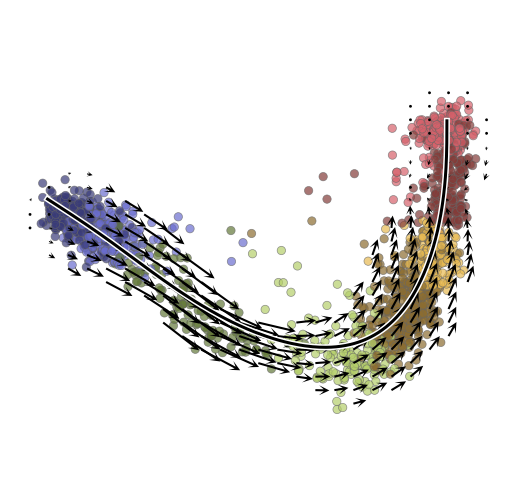

In [27]:
# try on "constant_unspliced assumption"
vlm.predict_U()  # basically gamma * S

# velocity is Ux - Upred = Ux - gamma * S_x
# and Ux is a normalized U, so the velocity is the difference from the real current U to the future predict U
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x
vlm.calculate_shift(assumption="constant_unspliced")  # the numerical integration step, but basically the velocity
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

2020-01-05 19:31:43,694 - DEBUG - Calculate transition probability
2020-01-05 19:31:43,708 - DEBUG - Calculate transition probability for negative control
2020-01-05 19:31:44,164 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


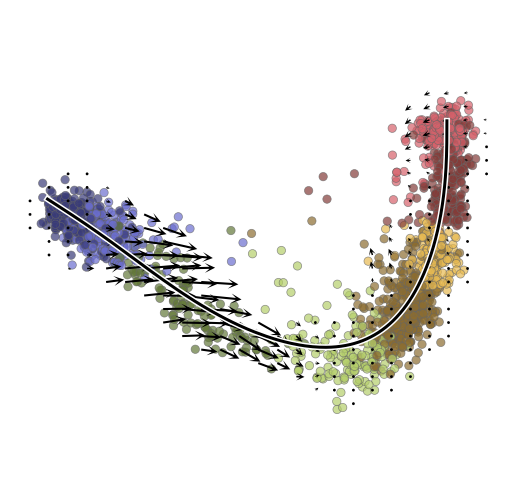

In [58]:
vlm.predict_U()  # basically gamma * S
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x
vlm.calculate_shift()  # the numerical integration step, but basically the velocity
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

# vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
#                              n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient
transition_prob2(vlm, features)

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

# the back2forward projection, change the similarity metric direction

2020-01-05 19:32:46,844 - DEBUG - Calculate transition probability
2020-01-05 19:32:46,857 - DEBUG - Calculate transition probability for negative control
2020-01-05 19:32:47,294 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


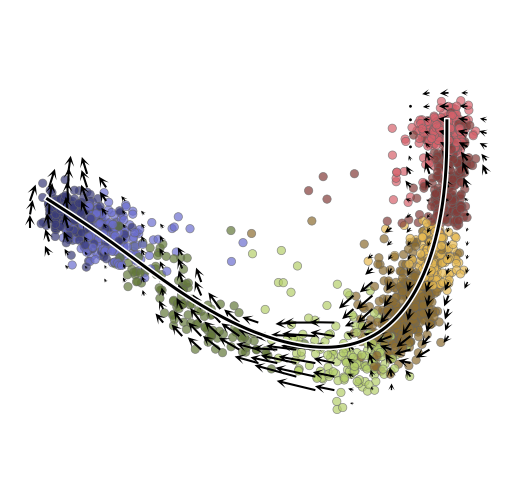

In [61]:
vlm.predict_U()  # basically gamma * S
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x
vlm.calculate_shift()  # the numerical integration step, but basically the velocity
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

# vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
#                              n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient
transition_prob3(vlm, features)

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

In [ ]:
vlm.predict_U()  # basically gamma * S
vlm.calculate_velocity()  # velocity is Ux - Upred = Ux - gamma * S_x
vlm.calculate_shift()  # the numerical integration step, but basically the velocity
vlm.extrapolate_cell_at_t(delta_t=1)  # calculate this one and then just have a look which one it looks like

# vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
#                              n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient
vlm.corrcoef = features

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

In [29]:
%%pixie_debugger
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)  # what it is doing with this one?! - compute the correlation coefficient
# clearly, it is the embedding_knn you have to change

# notes in the function
# the embedding is the pca features
# nn fit is based on the embedding, i.e., the pca features, only the 2-dimension
# neigh_ixs: the idx of the neighbors(and the cell itself), so (1720, K+1)
# p is (K+1,)=(151,), here is the probability assigned to every neighbor.
# 

2019-11-27 11:46:10,422 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd3c8b6de10>
2019-11-27 11:46:10,423 - DEBUG - Using auto colorbar locator on colorbar
2019-11-27 11:46:10,423 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fd3c8b6de10>
2019-11-27 11:46:10,423 - DEBUG - Setting pcolormesh


/home/haotian/anaconda3/envs/velocity/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


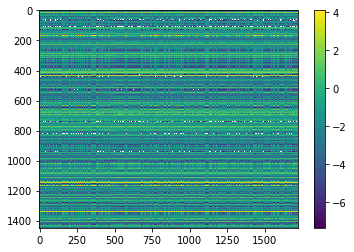

In [14]:
plt.imshow(np.log(vlm.Sx_sz)); plt.colorbar()

In [30]:
plt.imshow(np.log(vlm.delta_s)); plt.colorbar()

AttributeError: 'VelocytoLoom' object has no attribute 'delta_s'